# Example1_SingleSetup

First of all we import the necessary modules.

In [1]:
import os
import sys
# Add the directory we executed the script from to path:
sys.path.insert(0, os.path.realpath('__file__'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyoma2.algorithm import FDD_algo,FSDD_algo,SSIcov_algo
from pyoma2.OMA import SingleSetup

Then we import the dataset we want to analyse and assign it to a variable

In [2]:
# load example dataset for single setup
data = np.load("../src/pyoma2/test_data/palisaden/Palisaden_dataset.npy", allow_pickle=True)

 Now we can proceed to instantiate the SingleSetup class, passing the dataset and the sampling frequency as parameters

In [3]:
# create single setup
Pali_ss = SingleSetup(data, fs=100)

If we want to be able to plot the mode shapes, once we have the results, we need to define the geometry of the structure.
We have two different method available that offers unique plotting capabilities:
* The first method **def_geo1()** enables users to visualise mode shapes with arrows that represent the placement, direction, and magnitude of displacement for each sensor.
* The second method **def_geo2()** allows for the plotting and animation of mode shapes, with sensors mapped to user defined points.

In [4]:
# import geometry files
# Names of the channels
Names = ["ch1", "ch2", "ch3", "ch4", "ch5", "ch6"]
# Common Backgroung nodes and lines
BG_nodes = np.loadtxt("../src/pyoma2/test_data/palisaden/BG_nodes.txt")
BG_lines = np.loadtxt("../src/pyoma2/test_data/palisaden/BG_lines.txt").astype(int)
# Geometry 1
sens_coord = pd.read_csv("../src/pyoma2/test_data/palisaden/sens_coord.txt", sep="\t")
sens_dir = np.loadtxt("../src/pyoma2/test_data/palisaden/sens_dir.txt")
# Geometry 2
sens_lines = np.loadtxt("../src/pyoma2/test_data/palisaden/sens_lines.txt").astype(int)
pts_coord = pd.read_csv("../src/pyoma2/test_data/palisaden/pts_coord.txt", sep="\t")
sens_map = pd.read_csv("../src/pyoma2/test_data/palisaden/sens_map.txt", sep="\t")
sens_sign = pd.read_csv("../src/pyoma2/test_data/palisaden/sens_sign.txt", sep="\t")

# Define geometry1
Pali_ss.def_geo1(
    Names,  # Names of the channels
    sens_coord,  # coordinates of the sensors
    sens_dir,  # sensors' direction
    bg_nodes=BG_nodes,  # BG nodes
    bg_lines=BG_lines,  # BG lines
)

# Define geometry 2
Pali_ss.def_geo2(
    Names,  # Names of the channels
    pts_coord,  # name and coordinates of the points
    sens_map,  # mapping between points and sensors
    order_red="xy",  # argument to reduce the number of DOF per points
    sens_sign=sens_sign,  # sign of the sensor (respect to reference axis)
    sens_lines=sens_lines,  # lines connecting points
    bg_nodes=BG_nodes, # background nodes
    bg_lines=BG_lines, # background lines
)

Once we have defined the geometry we can show it calling the **plot_geo1()** or **plot_geo2()** methods.

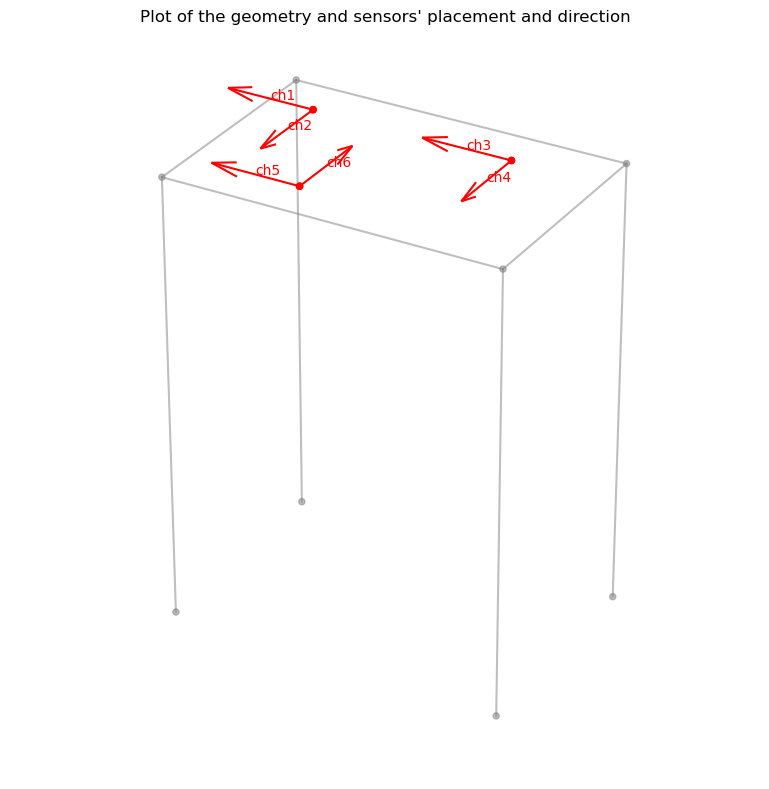

In [5]:
# Plot the geometry
fig, ax = Pali_ss.plot_geo1(scaleF=2)

If we need to detrend and/or decimate the signals we can do this using the **detrend_data()** and **decimate_data()** methods 

In [6]:
# Detrend and decimate
#Pali_ss.detrend_data()
Pali_ss.decimate_data(q=4) # q=decimation factor
print(Pali_ss.fs)

25.0


We can plot all the time histories of the channels calling the **plot_data()** method

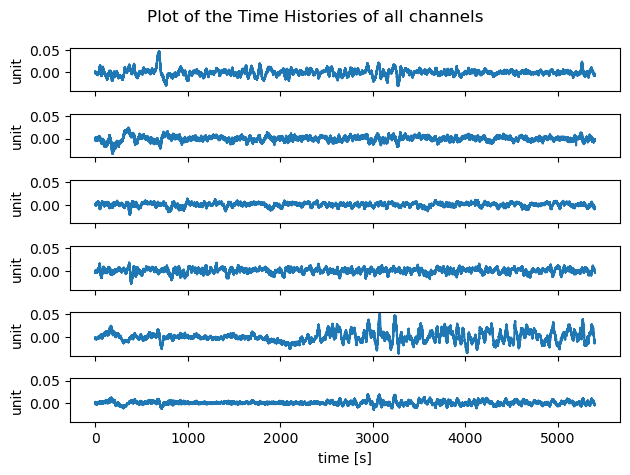

In [7]:
# Plot the Time Histories
fig1, ax1 = Pali_ss.plot_data()

We can also get more info regarding the quality of the data for each channel calling the **plot_ch_info()** method

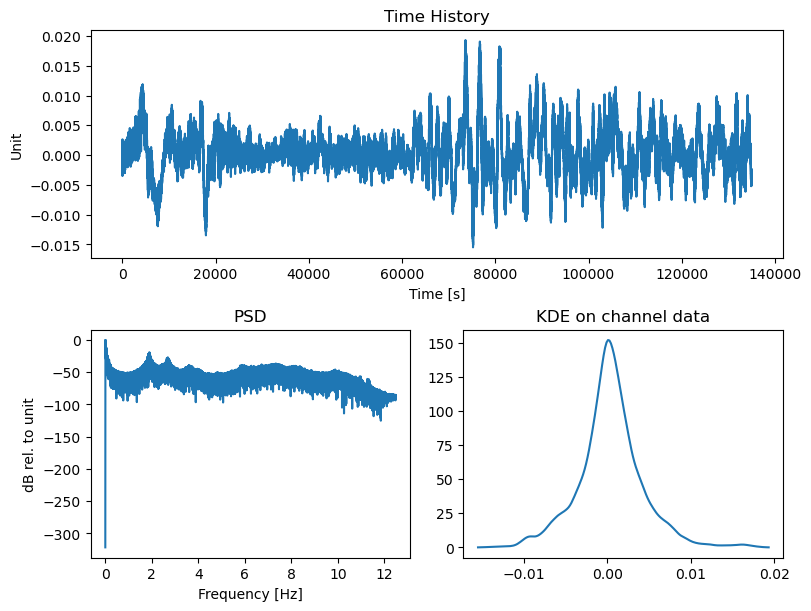

In [8]:
# Plot TH, PSD and KDE of the (selected) channels
fig2, ax2 = Pali_ss.plot_ch_info(ch_idx=[-1])

We need now to instantiate the algorithms that we want to run, e.g. **EFDD_algo** and **SSIcov_algo**. The algorithms must then be added to the setup class using the
**add_algorithms()** method.
Thereafter, the algorithms can be executed either individually using the **run_by_name()** method or collectively with **run_all()**.

In [9]:
# Initialise the algorithms
fdd = FDD_algo(name="FDD")
fsdd = FSDD_algo(name="FSDD", nxseg=2048, method_SD="per", pov=0.5)
ssicov = SSIcov_algo(name="SSIcov", br=50, ordmax=80)

# Overwrite/update run parameters for an algorithm
fdd.run_params = FDD_algo.RunParamCls(nxseg=512, method_SD="cor")
# Aggiungere esempio anche col metodo

# Add algorithms to the single setup class
Pali_ss.add_algorithms(ssicov, fsdd, fdd)

# Run all or run by name
Pali_ss.run_by_name("SSIcov")
Pali_ss.run_by_name("FSDD")
# Pali_ss.run_all()

# save dict of results
ssi_res = ssicov.result.model_dump()
fsdd_res = dict(fsdd.result)

2024-02-23 15:04:54,605 - pyoma2.OMA - INFO - Running SSIcov... (OMA:148)
100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 57.06it/s]
2024-02-23 15:04:56,422 - pyoma2.functions.SSI_funct - INFO - SSI for increasing model order... (SSI_funct:278)
100%|███████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 10125.43it/s]
2024-02-23 15:04:56,909 - pyoma2.OMA - INFO - Running FSDD... (OMA:148)


We can now plot some of the results:

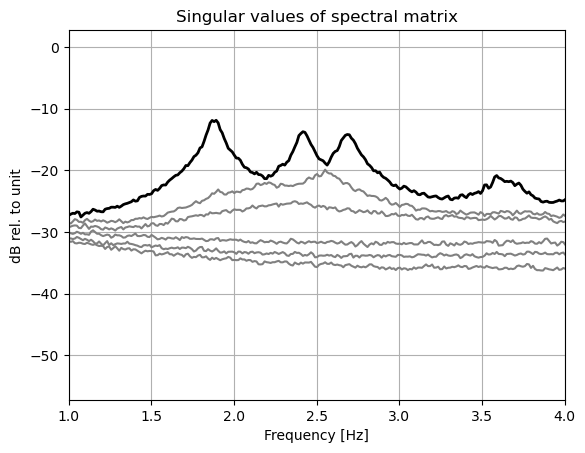

In [10]:
# plot Singular values of PSD
fig3, ax3 = fsdd.plot_CMIF(freqlim=(1,4))

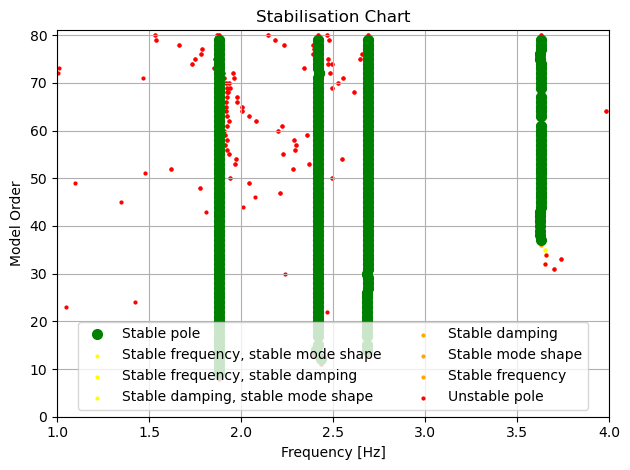

In [11]:
# plot Stabilisation chart for SSI
fig4, ax4 = ssicov.plot_STDiag(freqlim=(1,4), hide_poles=False)

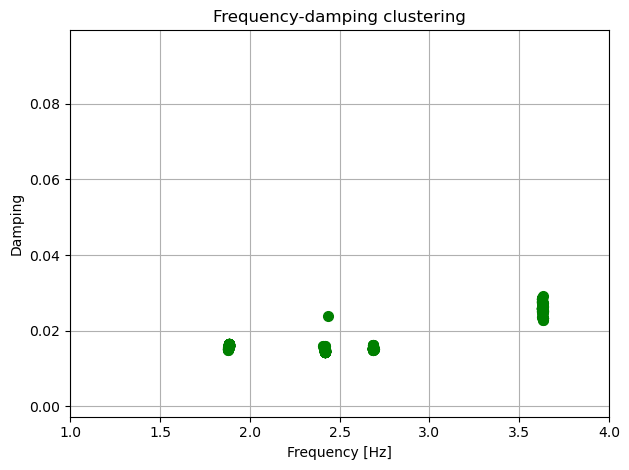

In [12]:
# plot frequecy-damping clusters for SSI
fig5, ax5 = ssicov.plot_cluster(freqlim=(1,4))

We are now ready to extract the modal properties of interest either from the interactive plots using the **MPE_fromPlot()** method or using the **MPE()** method.

In [13]:
# Select modes to extract from plots
# Pali_ss.MPE_fromPlot("SSIcov", freqlim=(1,4))

# or directly
Pali_ss.MPE("SSIcov", sel_freq=[1.88, 2.42, 2.68], order=40)

# update dict of results
ssi_res = dict(ssicov.result)

2024-02-23 15:04:58,561 - pyoma2.OMA - INFO - Getting MPE modal parameters from SSIcov (OMA:173)
2024-02-23 15:04:58,562 - pyoma2.functions.SSI_funct - INFO - Extracting SSI modal parameters (SSI_funct:632)
100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2995.93it/s]


In [14]:
# Select modes to extract from plots
# Pali_ss.MPE_fromPlot("FSDD", freqlim=(1,4), MAClim=0.95)

# or directly
Pali_ss.MPE("FSDD", sel_freq=[1.88, 2.42, 2.68], MAClim=0.95)

# update dict of results
fsdd_res = dict(fsdd.result)

2024-02-23 15:04:58,573 - pyoma2.OMA - INFO - Getting MPE modal parameters from FSDD (OMA:173)
2024-02-23 15:04:58,635 - pyoma2.functions.FDD_funct - INFO - Extracting FDD modal parameters (FDD_funct:276)
100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1996.65it/s]
2024-02-23 15:04:58,640 - pyoma2.functions.FDD_funct - INFO - Extracting EFDD modal parameters (FDD_funct:486)
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.36it/s]


We can compare the results from the two methods

In [15]:
ssicov.result.Fn

array([1.88211537, 2.42114222, 2.68853764])

In [16]:
fsdd.result.Fn

array([1.8787832 , 2.42254302, 2.67381079])

We can also plot some additional info regarding the estimates for the EFDD and FSDD algorithms

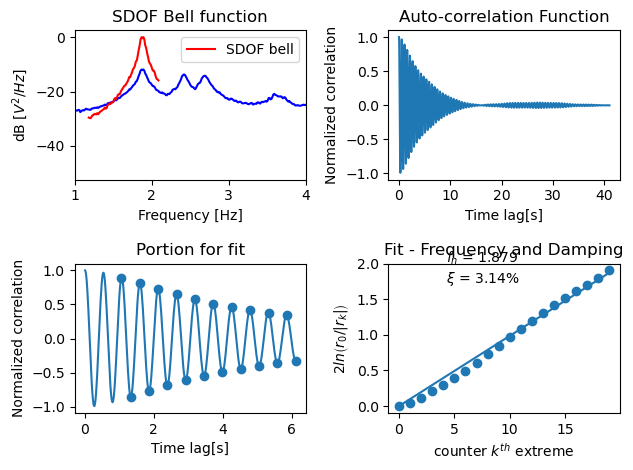

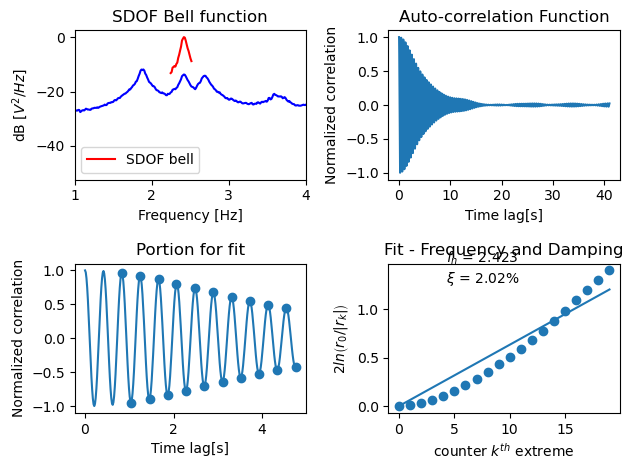

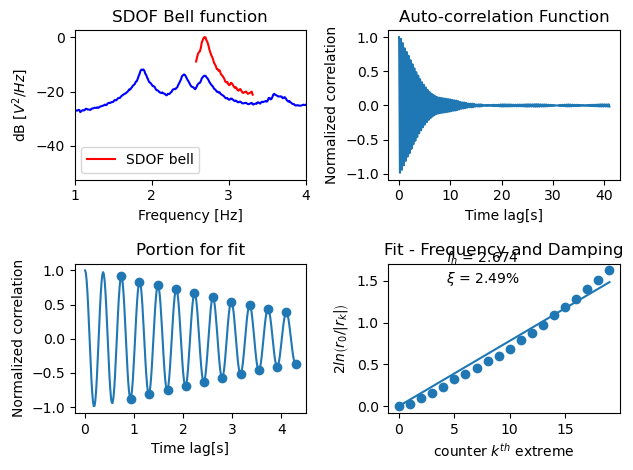

In [17]:
# plot additional info (goodness of fit) for EFDD or FSDD
figs, axs = Pali_ss[fsdd.name].plot_FIT(freqlim=(1,4))

And finally we can plot and/or animate the mode shapes extracted from the analysis

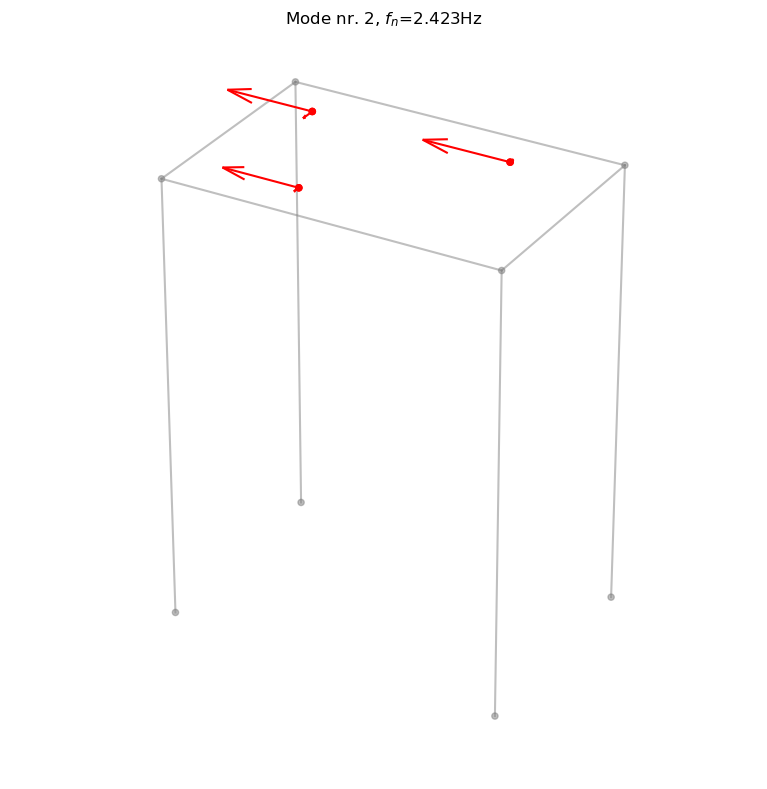

In [18]:
# MODE SHAPES PLOT
# Plot mode 2 (geometry 1)
fig7, ax7 = Pali_ss[fsdd.name].plot_mode_g1(
    Geo1=Pali_ss.Geo1, mode_numb=2, view="3D", scaleF=2)

In [19]:
# Animate mode 1 (geometry 2)
Pali_ss[ssicov.name].anim_mode_g2(
    Geo2=Pali_ss.Geo2, mode_numb=1, view="xy", scaleF=3)